# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [1]:
import neuro_op as nop
import matplotlib.pyplot as plt
# import networkx as nx
import numpy as np
import scipy.stats as st

In [2]:
input_dict = dict(
    N_nodes=100,
    N_neighbours=3,
    N_beliefs=500,
    belief_min=-50,
    belief_max=50,
    log_priors=np.zeros(500),
    likelihood=st.norm(loc=0, scale=5),
    world_dist=st.norm(loc=0, scale=5),
    h=1,
    r=1,
    t0=0,
    t_max=10000,
    t_sample=250,
    sample_bins=50,
    sample_opinion_range=[-20, 20],
)

output_variables = [
    "nodes",
    "G",
    "beliefs",
    "world",
    "N_events",
    "t_end",
    "kl_divs_means",
    "t_sample",
    "RANDOM_SEED",
]

In [3]:
output1 = dict(zip(
    output_variables,
    nop.run_model(**input_dict)
))

print(f"Number of events: {output1['N_events']}")

Sampling at t= 0


/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:223: RuntimeWarning: invalid value encountered in divide
  ppd_world_out = ppd_world_out[0] / np.sum(
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


Sampling at t= 250.13247528364573
Sampling at t= 500.19367116045856
Sampling at t= 750.5102914787958
Sampling at t= 1000.9207849245441
Sampling at t= 1250.478123429844
Sampling at t= 1500.9004772561354
Sampling at t= 1751.5168851067635
Sampling at t= 2000.0547080995505
Sampling at t= 2250.6485217082295
Sampling at t= 2501.960776541387
Sampling at t= 2750.6688427543777
Sampling at t= 3000.1065289160983
Sampling at t= 3250.467208642162
Sampling at t= 3501.5210588550467
Sampling at t= 3750.0006310078898
Sampling at t= 4000.1213575783318
Sampling at t= 4250.719451391012
Sampling at t= 4500.418178886336
Sampling at t= 4750.278566424899
Sampling at t= 5000.160017821308
Sampling at t= 5250.969011584473
Sampling at t= 5501.5837803132
Sampling at t= 5750.576817899577
Sampling at t= 6000.044183541413
Sampling at t= 6250.315106031315
Sampling at t= 6500.362519407217
Sampling at t= 6750.01991738005
Sampling at t= 7000.42729634732
Sampling at t= 7250.095838667421
Sampling at t= 7500.13464223176
Sam

In [26]:
input2_dict = input_dict.copy()
input2_dict["h"] = 0.1
input2_dict["r"] = 5
output2 = dict(zip(
    output_variables,
    nop.run_model(**input2_dict)
))
print(f"Number of events: {output2['N_events']}")

Sampling at t= 0


/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:223: RuntimeWarning: invalid value encountered in divide
  ppd_world_out = ppd_world_out[0] / np.sum(
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: divide by zero encountered in log
  terms = P * np.log(P / Q)
/home/jfriedel/Documents/Repos/neuro_op/src/neuro_op/neuro_op.py:135: RuntimeWarning: invalid value encountered in multiply
  terms = P * np.log(P / Q)


Sampling at t= 250.192751925309
Sampling at t= 500.501232185398
Sampling at t= 750.1223608004267
Sampling at t= 1000.105787595613
Sampling at t= 1250.3045012922692
Sampling at t= 1500.2291737185958
Sampling at t= 1750.0918936665557
Sampling at t= 2000.0001589879105
Sampling at t= 2250.3383826204463
Sampling at t= 2500.0036872093597
Sampling at t= 2750.1854955465374
Sampling at t= 3000.242932965235
Sampling at t= 3250.3461048122936
Sampling at t= 3500.039796836933
Sampling at t= 3750.2423858239326
Sampling at t= 4000.224756129616
Sampling at t= 4250.048983369036
Sampling at t= 4500.211001306431
Sampling at t= 4750.069573335085
Sampling at t= 5000.156046035875
Sampling at t= 5250.033947743301
Sampling at t= 5500.16431880423
Sampling at t= 5750.043693427803
Sampling at t= 6000.11053590669
Sampling at t= 6250.43675314161
Sampling at t= 6500.321059049491
Sampling at t= 6750.930239445819
Sampling at t= 7000.04216516439
Sampling at t= 7250.209286526749
Sampling at t= 7500.060634342461
Samplin

## Data analysis

After simulating the network with $h=1, r=0$ (meaning nodes communicating with the central node only), some simple analysis steps follow.



In [5]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
plt.rcParams.update(
    {
        "font.size": 20,
        "legend.loc": "upper right",
    }
)

#### Data analysis 1

Firstly, extract output values for further analysis:

In [28]:
 for key, value in output2.items():
    globals()[key] = value


Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


Text(0, 0.5, '$p(\\mu|x_i)$')

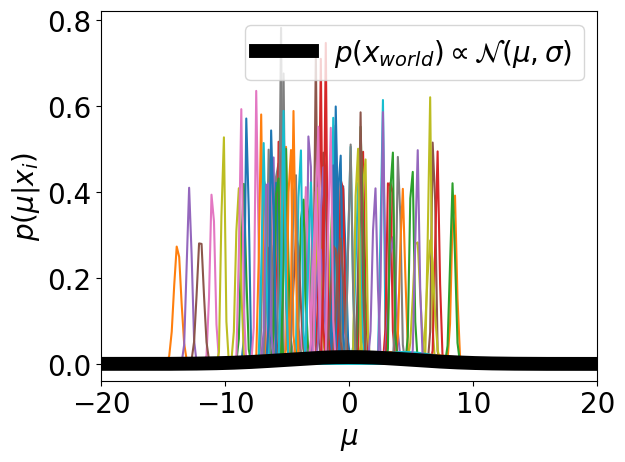

In [29]:
for i in range(len(nodes)):
    plt.plot(nodes[0].beliefs, nop.logpdf_to_pdf(nodes[i].log_probs))
    plt.xlim([-20, 20])
plt.plot(
    beliefs,
    nop.logpdf_to_pdf(world.log_probs),
    color="black",
    linewidth=10,
    label="$p(x_{world}) \propto \mathcal{N}(\mu,\sigma)$",
)
plt.legend()
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu|x_i)$")

#### Data analysis 2

Each node executes posterior predictive distribution sampling to generate a forecast of expected future data.

For some eye-balling analysis, histograms of `world_dist`'s and some nodes' PPD samples are plotted.

In [8]:
# Define parameters of data analysis
N_bins = 50  # go for uneven bin number to have a bin centered on 0
opinion_range = [-20, 20]  # chosen by experience, no formal reasoning

# Generate posterior predictive distributions (PPDs) for each node by generating ppd samples and binning them into histograms
ppd_samples = [
    nop.ppd_Gaussian_mu(node.beliefs, node.log_probs, 10000) for node in nodes
    ]
ppds = [  # PPD stored as histograms. Each histogram is a tuple (counts, bin_edges).
    np.histogram(
        i,
        bins=N_bins,
        range=opinion_range,
    )
    for i in ppd_samples
]

ppd_world = np.histogram(
    world.diary_out,
    bins=N_bins,
    range=opinion_range,
)

world_binned = nop.dist_binning(world.likelihood, N_bins, opinion_range)

# Save the centre of each node's bin with most samples.
# We then assume 'centres of each node's bin with most samples' == 'maximum likelihood estimates (MLEs) of each node')
argmax = np.argmax(ppd_world[0])
mu_world = (ppd_world[1][argmax] + ppd_world[1][argmax + 1]) / 2

argmax = [np.argmax(ppds_hist[0]) for ppds_hist in ppds]
mu_nodes = [
    (hist_data[1][i] + hist_data[1][i + 1]) / 2 for hist_data, i in zip(ppds, argmax)
]

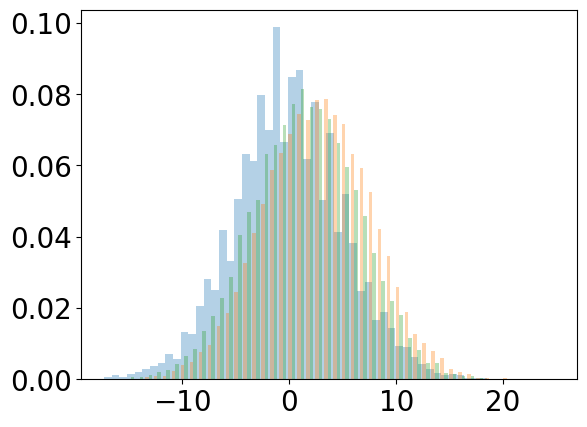

In [9]:
for i in [world.diary_out, ppd_samples[:2]]:
    plt.hist(i, bins=N_bins, density=True, alpha=1/3)

Mean KL divergence:	 0.10447099264587012
Mean linear p-distance:	 2.983999999999999
Mean quad. p-distance:	 11.897599999999994


(array([37.,  9.,  8.,  4.,  5.,  8.,  4.,  6.,  4.,  4.,  1.,  4.,  2.,
         0.,  0.,  0.,  2.,  1.,  0.,  1.]),
 array([0.00173366, 0.02615943, 0.0505852 , 0.07501096, 0.09943673,
        0.1238625 , 0.14828827, 0.17271403, 0.1971398 , 0.22156557,
        0.24599134, 0.27041711, 0.29484287, 0.31926864, 0.34369441,
        0.36812018, 0.39254595, 0.41697171, 0.44139748, 0.46582325,
        0.49024902]),
 <BarContainer object of 20 artists>)

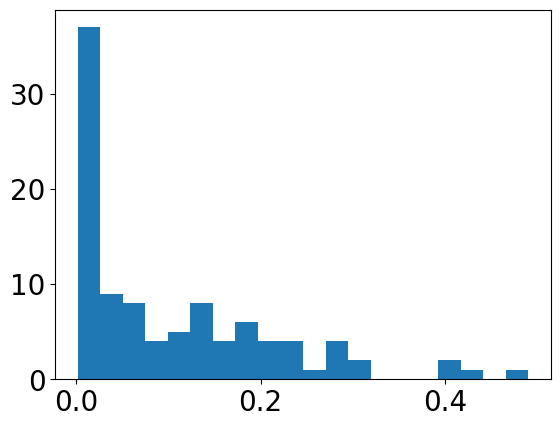

In [10]:
kl_divs = []
for i in ppds:
    P_sampled = i[0] / np.sum(i[0])
    kl_divs.append(nop.kl_divergence(P_sampled, world_binned))

print(f"Mean KL divergence:\t {np.mean(kl_divs)}")
print(f"Mean linear p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=1)/len(nodes)}")
print(f"Mean quad. p-distance:\t {nop.p_distances(mu_nodes, mu_world, p=2)/len(nodes)}")
plt.hist(kl_divs, bins=20)


[array([       nan, 1.56028089]), array([7.9363463 , 1.01143818]), array([2.62854371, 0.62428271]), array([1.42347768, 0.47702544]), array([1.08023637, 0.39813497]), array([0.91629995, 0.33783196]), array([0.81774989, 0.30347851]), array([0.72178545, 0.2786555 ]), array([0.65566199, 0.26341377]), array([0.5896869 , 0.24570129]), array([0.54357305, 0.22980601]), array([0.39786451, 0.22262894]), array([0.36049735, 0.21220367]), array([0.31098216, 0.20613418]), array([0.30282797, 0.19979494]), array([0.29032417, 0.19115577]), array([0.27601141, 0.18377926]), array([0.27115117, 0.17907551]), array([0.25519674, 0.17338627]), array([0.23998011, 0.17299841]), array([0.23740037, 0.17014531]), array([0.23623693, 0.16187927]), array([0.23293701, 0.15805037]), array([0.22888139, 0.15549747]), array([0.23101612, 0.15580755]), array([0.2247344 , 0.15205893]), array([0.22206634, 0.14979426]), array([0.21659277, 0.14795205]), array([0.20745612, 0.14671022]), array([0.20615945, 0.14035032]), array([0.

Text(0, 0.5, '$KLD(P(t),Q(t))$')

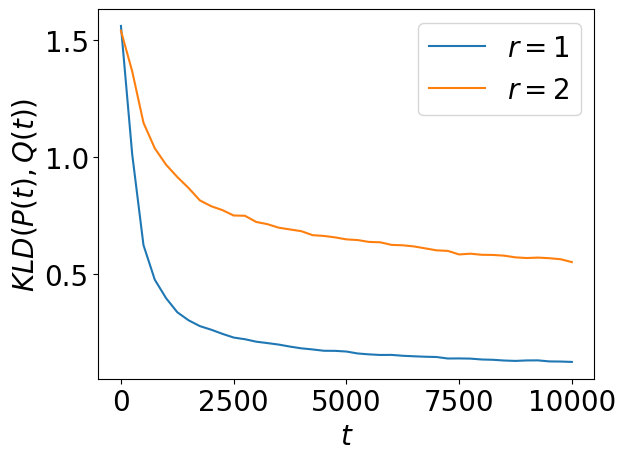

In [27]:
kld_1 = np.array(kl_divs_means)[:,1]
kld_2 = np.array(output2["kl_divs_means"])[:,1]
print(kl_divs_means)

plt.plot(range(0, int(t_end+1), t_sample), kld_1,
    label="$r=1$"
)
plt.plot(range(0, int(t_end+1), t_sample), kld_2,
    label="$r=2$"
)
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$KLD(P(t),Q(t))$")